In [2]:
#!brew install graphviz
#%pip install graphviz
from graphviz import Digraph
import math
import random
random.seed(20251229)

In [3]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0
    self.label = label
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op

  def __add__(self, other): # self + other
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += out.grad
      other.grad += out.grad
    out._backward = _backward
    
    return out
  
  def __mul__(self, other): # self * other
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    
    return out
  
  def __pow__(self, other): # self ** other
    assert isinstance(other, (int, float))
    out = Value(self.data ** other, (self,), f'**{other}')
    
    def _backward():
      self.grad += other * self.data ** (other - 1) * out.grad
    out._backward = _backward
    
    return out

  def relu(self):
      out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')
      
      def _backward():
        self.grad += (out.data > 0) * out.grad
      out._backward = _backward
      
      return out
  
  def tanh(self):
    t = (math.exp(2*self.data) - 1)/(math.exp(2*self.data) + 1)
    out = Value(t, (self,), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    out = Value(math.exp(self.data), (self,), 'exp')
    
    def _backward():
      self.grad += math.exp(self.data) * out.grad
    out._backward = _backward
    
    return out
  
  def __neg__(self): # -self
      return self * -1
  
  def __radd__(self, other): # other + self
      return self + other
  
  def __sub__(self, other): # self - other
      return self + (-other)
  
  def __rsub__(self, other): # other - self
      return other + (-self)
  
  def __rmul__(self, other): # other * self
      return self * other
  
  def __truediv__(self, other): # self / other
      return self * other**-1
  
  def __rtruediv__(self, other): # other / self
      return other * self**-1

  def backward(self):
      # topological order all of the children in the graph
      topo = []
      visited = set()
      def build_topo(v):
          if v not in visited:
              visited.add(v)
              for child in v._prev:
                  build_topo(child)
              topo.append(v)
      build_topo(self)
      # go one variable at a time and apply the chain rule to get its gradient
      self.grad = 1
      for v in reversed(topo):
          v._backward()

  def __repr__(self):
    if self.label:
      return f"Value(data={self.data}, grad={self.grad}, label={self.label})"
    else:
      return f"Value(data={self.data}, grad={self.grad})"

In [4]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ label %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [5]:
a = Value(-4.0)
b = Value(2.0)
c = a + b
c

Value(data=-2.0, grad=0)

In [6]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'
o.backward()
o

Value(data=0.7071067811865476, grad=1, label=o)

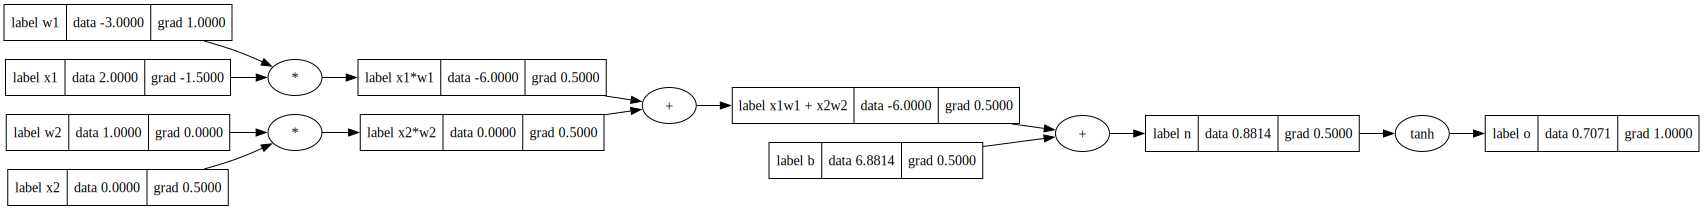

In [7]:
draw_dot(o)

In [8]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad=True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad=True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad=True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad=True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad=True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


In [9]:
class Module:
  def zero_grad(self):
    for p in self.parameters():
      p.grad = 0

  def parameters(self):
    return []

class Neuron(Module):
  def __init__(self, nin, nonlin=True):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(0)
    self.nonlin = nonlin

  def __call__(self, x):
    act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
    return act.relu() if self.nonlin else act

  def parameters(self):
    return self.w + [self.b]

  def __repr__(self):
    return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

  def __init__(self, nin, nout, **kwargs):
    self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

  def __call__(self, x):
    out = [n(x) for n in self.neurons]
    return out[0] if len(out) == 1 else out

  def parameters(self):
    return [p for n in self.neurons for p in n.parameters()]

  def __repr__(self):
    return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

  def __repr__(self):
    return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [10]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [11]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.2507906113683852, grad=0)

In [12]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.2507906113683852, grad=0),
 Value(data=0.2559376684245028, grad=0),
 Value(data=-0.24738881988939904, grad=0),
 Value(data=-0.20769556956665958, grad=0)]

In [13]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # mean squard error
loss

Value(data=5.166808757633285, grad=0)

In [14]:
loss.backward()

print('w0 data', n.layers[0].neurons[0].w[0].data)
print('w0 grad', n.layers[0].neurons[0].w[0].grad)

w0 data 0.543425150665432
w0 grad 0.652957745833955


In [15]:
n.parameters()[:5]

[Value(data=0.543425150665432, grad=0.652957745833955),
 Value(data=0.5973791125017955, grad=1.7015119907824512),
 Value(data=0.840528474267562, grad=-1.084217207562681),
 Value(data=0, grad=0.49931114605737337),
 Value(data=0.3265716441228079, grad=-1.817392356250288)]

Durch den Gradienten wissen wir, in welche Richtung die Gewichte der Neuronen angepasst werden müssen, um den Loss in eine bestimmte Richtung zu verändern. Wenn man Gewicht+Gradient rechnet, würde das den Loss vergrößern. Um den Loss zu minimieren wird der Gradient subtrahiert. Durch die Multiplikation mit einer LearningRate wird gesteuert wie stark die Gewichtung in Richtung des Gradienten angepasst werden. Also insgesamt: $w_i = w_i - LR \cdot grad_i$

In [16]:
for p in n.parameters():
  p.data += -0.01 * p.grad

ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.229231676830303, grad=0)

In [17]:
steps = 100
lr = 0.01

for _ in range(steps):
  # forward
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward
  n.zero_grad()
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -lr * p.grad

print('loss', loss.data)
print('actual\t pred\n', '\n'.join(f'{ygt} \t {yout.data}' for ygt, yout in zip(ys, ypred)))


loss 0.00018299095420808706
actual	 pred
 1.0 	 1.0061111831478127
-1.0 	 -0.9998214025214792
-1.0 	 -1.0009785034567995
1.0 	 0.9879727381059663
